In [1]:
# extension to agent copy 4.ipynb F1-score, pos weight
from typing import Tuple, List
from dataclasses import dataclass
from tqdm import tqdm
from datetime import timedelta
import zipfile
import shutil
import tempfile
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import time
import os
import glob
from torch.utils.data import Subset, DataLoader

In [ ]:
class VoxelDataLoader:
    """Loads and processes NPZ voxel data from a zip file"""

    def __init__(self, zip_path: str):
        # Create a temporary directory
        self.temp_dir = tempfile.mkdtemp()
        print(f"Created temporary directory: {self.temp_dir}")

        # Extract zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(self.temp_dir)
        print(f"Extracted zip file to temporary directory")

        # Find all NPZ files
        all_files = glob.glob(os.path.join(self.temp_dir, "**/*.npz"), recursive=True)
        print(f"Found {len(all_files)} total NPZ files")

        if len(all_files) == 0:
            raise ValueError(f"No NPZ files found in zip file")

        random.shuffle(all_files)  # Shuffle before splitting
        cutoff = int(len(all_files))
        self.npz_files = all_files[:cutoff]
        print(f"Using {len(self.npz_files)}")

    def __del__(self):
        """Cleanup temporary directory when object is destroyed"""
        try:
            shutil.rmtree(self.temp_dir)
            print(f"Cleaned up temporary directory: {self.temp_dir}")
        except:
            print(f"Failed to clean up temporary directory: {self.temp_dir}")

    def load_single_file(self, file_path: str) -> Tuple[torch.Tensor, torch.Tensor]:
        data = np.load(file_path)

        # More robust key checking
        if 'complete' not in data or 'partial' not in data:
            raise ValueError(f"NPZ file {file_path} must contain both 'complete' and 'partial' arrays")

        complete = torch.from_numpy(data['complete']).float()
        partial = torch.from_numpy(data['partial']).float()

        # Verify shapes match
        if complete.shape != partial.shape:
            raise ValueError(f"Shape mismatch in {file_path}: complete {complete.shape} vs partial {partial.shape}")

        return complete, partial

    def get_all_data(self) -> List[Tuple[torch.Tensor, torch.Tensor]]:
        """Load all voxel pairs from all NPZ files"""
        all_data = []
        for file_path in self.npz_files:
            complete, partial = self.load_single_file(file_path)
            all_data.append((complete, partial))
        return all_data

    def get_voxel_grids(self, index: int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
        """Returns complete and partial voxel grids from a specific file"""
        if index >= len(self.npz_files):
            raise IndexError(f"Index {index} out of range. Only {len(self.npz_files)} files available.")
        return self.load_single_file(self.npz_files[index])


class VoxelDataset(torch.utils.data.Dataset):
    """PyTorch Dataset for voxel completion"""

    def __init__(self, zip_path: str, transform=None):
        self.data_loader = VoxelDataLoader(zip_path)
        self.transform = transform

    def __len__(self):
        return len(self.data_loader.npz_files)

    def __getitem__(self, idx):
        complete, partial = self.data_loader.get_voxel_grids(idx)
        # Normalize to [0,1] if not already
        complete = (complete > 0).float()
        partial = (partial > 0).float()
        if self.transform:
            complete, partial = self.transform(complete, partial)
        return complete, partial


# Update data loader creation function
def create_data_loader(zip_path: str, batch_size: int = 1, shuffle: bool = True, num_workers: int = 0):
    """Create a PyTorch DataLoader for training"""
    dataset = VoxelDataset(zip_path)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        # pin_memory=True
    )


def split_dataset(dataset, train_ratio=0.8, val_ratio=0.2, seed=42):
    n = len(dataset)
    indices = list(range(n))
    random.Random(seed).shuffle(indices)

    # from dataset: 80% train 20% test 
    n_trainval = int(n * 0.8)
    n_test = n - n_trainval
    trainval_indices = indices[:n_trainval]
    test_indices = indices[n_trainval:]
    # from training data: 80% train 20% validation
    n_train = int(len(trainval_indices) * 0.8)
    train_indices = trainval_indices[:n_train]
    val_indices = trainval_indices[n_train:]

    return train_indices, val_indices, test_indices

def create_data_loaders(zip_path, batch_size=1, shuffle=True, num_workers=0, seed=42):
    dataset = VoxelDataset(zip_path)
    print(f"Dataset size: {len(dataset)}")
    train_idx, val_idx, test_idx = split_dataset(dataset, seed=seed)
    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

class SpatialAttention3D(nn.Module):
    """
    Efficient 3D spatial attention with proper windowing.
    Maintains 3D structure throughout (never flattens below 3D).
    At each level, attention looks in all 6 directions (behind, in front, left, right, above, under) via 3D windowing.
    Now supports dynamic window size per forward pass.
    """
    def __init__(self, d_model: int, num_heads: int = 4, window_size: int = 3):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.window_size = window_size
        self.head_dim = d_model // num_heads
        assert d_model % num_heads == 0
        self.qkv = nn.Conv3d(d_model, d_model * 3, kernel_size=1)
        self.proj = nn.Conv3d(d_model, d_model, kernel_size=1)
        self.scale = self.head_dim ** -0.5
        self.attn_weights= None

    def forward(self, x, window_size=None):
        B, C, D, H, W = x.shape
        # Generate Q, K, V
        qkv = self.qkv(x)  # [B, 3*C, D, H, W]
        q, k, v = qkv.chunk(3, dim=1)  # Each: [B, C, D, H, W]
        # Reshape for multi-head attention
        q = q.view(B, self.num_heads, self.head_dim, D, H, W)
        k = k.view(B, self.num_heads, self.head_dim, D, H, W)
        v = v.view(B, self.num_heads, self.head_dim, D, H, W)
        # Extract windows efficiently using unfold
        ws = window_size if window_size is not None else self.window_size
        pad = ws // 2
        # Pad the tensors
        q_pad = F.pad(q, [pad]*6, mode='constant', value=0)
        k_pad = F.pad(k, [pad]*6, mode='constant', value=0)
        v_pad = F.pad(v, [pad]*6, mode='constant', value=0)
        # Extract windows - much more efficient than conv3d approach
        def extract_windows(tensor):
            # tensor: [B, heads, head_dim, D_pad, H_pad, W_pad]
            windows = tensor.unfold(3, ws, 1).unfold(4, ws, 1).unfold(5, ws, 1)
            # Result: [B, heads, head_dim, D, H, W, ws, ws, ws]
            return windows.contiguous()
        q_win = extract_windows(q_pad)  # [B, heads, head_dim, D, H, W, ws, ws, ws]
        k_win = extract_windows(k_pad)
        v_win = extract_windows(v_pad)
        # Get center query for each position
        center = ws // 2
        q_center = q_win[:, :, :, :, :, :, center, center, center]  # [B, heads, head_dim, D, H, W]
        # Flatten spatial dimensions of windows
        k_flat = k_win.view(B, self.num_heads, self.head_dim, D, H, W, ws*ws*ws)
        v_flat = v_win.view(B, self.num_heads, self.head_dim, D, H, W, ws*ws*ws)
        # Compute attention scores
        q_center = q_center.permute(0, 1, 3, 4, 5, 2).unsqueeze(-1)
        k_flat = k_flat.permute(0, 1, 3, 4, 5, 2, 6)
        v_flat = v_flat.permute(0, 1, 3, 4, 5, 2, 6)
        # Attention computation
        attn_scores = (q_center * k_flat).sum(dim=-2) * self.scale  # [B, heads, D, H, W, ws³]
        attn_weights = F.softmax(attn_scores, dim=-1)
        # Apply attention to values
        attn_out = (attn_weights.unsqueeze(-2) * v_flat).sum(dim=-1)  # [B, heads, D, H, W, head_dim]
        # Reshape back to original format
        attn_out = attn_out.permute(0, 1, 5, 2, 3, 4).contiguous()  # [B, heads, head_dim, D, H, W]
        attn_out = attn_out.view(B, C, D, H, W)
        # Final projection
        out = self.proj(attn_out)
        self.attn_weights = attn_weights  # Store attention weights for analysis if needed

        return out


class VoxelTransformerLayer3D(nn.Module):
    """
    Complete transformer layer with proper normalization and residuals.
    Now supports dynamic window size for attention.
    """
    def __init__(self, d_model: int, num_heads: int = 8, window_size: int = 3, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.window_size = window_size
        
        # Layer normalization (adapted for 3D)
        self.norm1 = nn.GroupNorm(1, d_model)  # GroupNorm works better for 3D than LayerNorm
        self.norm2 = nn.GroupNorm(1, d_model)
        
        # Attention
        self.attention = SpatialAttention3D(d_model, num_heads, window_size)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Conv3d(d_model, d_model * 4, kernel_size=1),
            nn.GELU(),
            nn.Dropout3d(dropout),
            nn.Conv3d(d_model * 4, d_model, kernel_size=1),
            nn.Dropout3d(dropout)
        )
        
        self.dropout = nn.Dropout3d(dropout)
        
    def forward(self, x, window_size=None):
        # Attention block with residual connection
        norm_x = self.norm1(x)
        attn_out = self.attention(norm_x, window_size=window_size)
        x = x + self.dropout(attn_out)
        
        # FFN block with residual connection
        norm_x = self.norm2(x)
        ffn_out = self.ffn(norm_x)
        x = x + ffn_out
        
        return x


class PositionalEncoding3D(nn.Module):
    """
    Learned 3D positional encoding for voxel grids.
    """
    def __init__(self, d_model: int, max_grid_size: int = 16):
        super().__init__()
        self.d_model = d_model
        self.max_grid_size = max_grid_size
        # Learnable positional embedding for each voxel position
        self.pos_embed = nn.Parameter(
            torch.zeros(1, d_model, max_grid_size, max_grid_size, max_grid_size)
        )
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        # x: [B, d_model, D, H, W]
        _, _, D, H, W = x.shape
        return self.pos_embed[:, :, :D, :H, :W]


class VoxelCompletionTransformer(nn.Module):
    """
    Improved 3D transformer for voxel completion.
    Predicts in a single level at the given window size.
    """
    def __init__(self, d_model: int = 64, num_heads: int = 8, num_layers: int = 4,
                 max_grid_size: int = 16, window_size: int = 3, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.max_grid_size = max_grid_size
        self.num_layers = num_layers
        self.window_size = window_size
        # Input projection
        self.input_proj = nn.Conv3d(1, d_model, kernel_size=1)
        # Positional encoding
        self.pos_encoding = PositionalEncoding3D(d_model, max_grid_size)
        # Transformer layers
        self.layers = nn.ModuleList([
            VoxelTransformerLayer3D(d_model, num_heads, window_size, dropout)
            for _ in range(num_layers)
        ])
        # Output projection
        self.output_norm = nn.GroupNorm(1, d_model)
        self.output_proj = nn.Conv3d(d_model, 1, kernel_size=1)
        # Initialize weights
        self.apply(self._init_weights)
    def _init_weights(self, m):
        if isinstance(m, nn.Conv3d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    def forward(self, x, window_size=None):
        # x: [B, 1, D, H, W]
        x = self.input_proj(x)  # [B, d_model, D, H, W]
        x = x + self.pos_encoding(x)
        ws = window_size if window_size is not None else self.window_size
        for layer in self.layers:
            x = layer(x, window_size=ws)
        x = self.output_norm(x)
        x = self.output_proj(x)  # [B, 1, D, H, W]
        return x


def masked_bce_loss(preds, targets, partial_grid, criterion):
    # Mask for unknown voxels (where partial is 0)
    unknown_mask = (partial_grid == 0)
    # Only compute BCE loss on unknown voxels
    masked_loss = criterion(preds * unknown_mask, targets * unknown_mask)
    # Avoid division by zero
    denom = unknown_mask.float().sum() + 1e-6
    return (masked_loss * unknown_mask.float()).sum() / denom

def consistency_loss(preds, partial_grid):
    # Penalize changes to known voxels (where partial is 1)
    known_mask = (partial_grid == 1)
    return F.mse_loss(preds * known_mask, partial_grid * known_mask)


def compute_pos_weight(dataset, sample_size=100):
    """Estimate pos_weight for BCEWithLogitsLoss based on dataset occupancy."""
    total_occupied = 0
    total_empty = 0
    n = min(sample_size, len(dataset))
    for i in range(n):
        complete, _ = dataset[i]
        total_occupied += (complete > 0.5).sum().item()
        total_empty += (complete <= 0.5).sum().item()
    if total_occupied == 0:
        return torch.tensor([1.0])
    return torch.tensor([total_empty / total_occupied])


def train_model(
    model: nn.Module,
    train_set,
    val_set,
    num_epochs: int = 50,
    batch_size: int = 1,
    window_size: int = 3,
    lambda_consistency: float = 1.0,
    seed: int = 42
):
    """Training loop for the voxel completion model with improved loss functions."""
    torch.cuda.empty_cache()
    torch.backends.cuda.enable_mem_efficient_sdp(True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    print(f"Train loader size: {len(train_loader)}, Val loader size: {len(val_loader)}")
    # Compute pos_weight for BCEWithLogitsLoss
    pos_weight = compute_pos_weight(train_set)
    print(f"Using pos_weight for BCEWithLogitsLoss: {pos_weight.item():.2f}")
    criterion = nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
    total_start_time = time.time()
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_loss = 0
        num_samples_processed = 0
        model.train()
        epoch_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True, unit='sample')
        for batch_idx, (complete_grid, partial_grid) in enumerate(epoch_pbar):
            complete_grid = complete_grid.to(device, non_blocking=True)
            partial_grid = partial_grid.to(device, non_blocking=True)
            optimizer.zero_grad()
            if partial_grid.dim() == 4:
                partial_grid = partial_grid.unsqueeze(1)
            if complete_grid.dim() == 4:
                complete_grid = complete_grid.unsqueeze(1)
            with torch.cuda.amp.autocast(enabled=(scaler is not None)):
                preds = model(partial_grid, window_size=window_size)
                masked_loss = masked_bce_loss(preds, complete_grid, partial_grid, criterion)
                cons_loss = consistency_loss(preds, partial_grid)
                total_batch_loss = masked_loss + lambda_consistency * cons_loss
            if scaler is not None:
                scaler.scale(total_batch_loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                total_batch_loss.backward()
                optimizer.step()
            total_loss += total_batch_loss.item()
            num_samples_processed += 1
            del complete_grid, partial_grid, preds, masked_loss, cons_loss, total_batch_loss
            torch.cuda.empty_cache()
            epoch_pbar.set_postfix({
                'train_loss': f'{total_loss/num_samples_processed:.4f}',
                'samples': num_samples_processed,
                'lr': optimizer.param_groups[0]['lr']
            })
        avg_train_loss = total_loss / max(num_samples_processed, 1)
        # Validation
        model.eval()
        val_loss = 0
        val_samples = 0
        with torch.no_grad():
            for complete_grid, partial_grid in val_loader:
                complete_grid = complete_grid.to(device, non_blocking=True)
                partial_grid = partial_grid.to(device, non_blocking=True)
                if partial_grid.dim() == 4:
                    partial_grid = partial_grid.unsqueeze(1)
                if complete_grid.dim() == 4:
                    complete_grid = complete_grid.unsqueeze(1)
                preds = model(partial_grid, window_size=window_size)
                masked_loss = masked_bce_loss(preds, complete_grid, partial_grid, criterion)
                cons_loss = consistency_loss(preds, partial_grid)
                total_batch_loss = masked_loss + lambda_consistency * cons_loss
                val_loss += total_batch_loss.item()
                val_samples += 1
                del complete_grid, partial_grid, preds, masked_loss, cons_loss, total_batch_loss
                torch.cuda.empty_cache()
        avg_val_loss = val_loss / max(val_samples, 1)
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {timedelta(seconds=int(epoch_time))}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Samples: {num_samples_processed}")
    total_time = time.time() - total_start_time
    print(f"\nTraining completed in {timedelta(seconds=int(total_time))}")
    print(f"Average time per epoch: {timedelta(seconds=int(total_time/num_epochs))}")



In [3]:
# !pip install google-auth-oauthlib

# from google.colab import drive
# drive.mount('/content/drive')

# DRIVE_PATH = "/content/drive/MyDrive/AUB_masters/thesis/data/partial_data_16.zip"  # Adjust this path to match your Drive structure
# LOCAL_PATH = "/content/partial_data"
# !mkdir -p {LOCAL_PATH}

# print("Copying data from Drive to local storage...")
# !cp "{DRIVE_PATH}" "{LOCAL_PATH}/data.zip"
# zip_path = f"{LOCAL_PATH}/data.zip"

In [ ]:
zip_path = "../../chunk_data_16_flood_fill_rm_40.zip"
dataset = VoxelDataset(zip_path)

print(f"Total dataset size: {len(dataset)}")

train_idx, val_idx, test_idx = split_dataset(dataset, seed=42)
train_set = torch.utils.data.Subset(dataset, train_idx)
val_set = torch.utils.data.Subset(dataset, val_idx)
test_set = torch.utils.data.Subset(dataset, test_idx)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

model = VoxelCompletionTransformer(
    d_model=48,        
    num_heads=6,       
    num_layers=6,      
    window_size=3,    
    dropout=0.1
).to(device)

print("Starting training...")
torch.cuda.empty_cache()
# best model before this was num_epochs=2
train_model(model, train_set, val_set, num_epochs=5, batch_size=2, lambda_consistency=1)

In [3]:
MODEL_SAVE_PATH = "../../models/model_rm_40_flood_fill/trained_model_rm_40.pth"
# os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
# torch.save({
#     'model_state_dict': model.state_dict(),
# }, MODEL_SAVE_PATH)
# print(f"Model saved to {MODEL_SAVE_PATH}")

In [4]:
import numpy as np
import torch
import glob
import json 

load_dir = "../../test_data/test_data_rm_40/"
test_samples = []

for file in sorted(glob.glob(os.path.join(load_dir, "test_*.npz"))):
    data = np.load(file)
    complete = torch.from_numpy(data['complete']).float()
    partial = torch.from_numpy(data['partial']).float()
    test_samples.append((complete, partial))
    
# zip_path = "../../chunk_data_16_flood_fill_rm_40.zip"
# dataset = VoxelDataset(zip_path)

# test_dir = "../../test_data/test_data_rm_40/"
# test_indices_file = os.path.join(test_dir, "test_indices.json")

# with open(test_indices_file, "r") as f:
#     test_idx = json.load(f)

# test_samples = []
# for idx in test_idx:
#     complete, partial = dataset[idx]
#     test_samples.append((complete, partial))

# print(f"Loaded {len(test_samples)} test samples from {test_dir}")



In [22]:
# --- Updated test_model to use test_set ---
from torchviz import make_dot
import torch
from torchinfo import summary

def test_model(model_path, test_set, sample_idx=0, threshold=0.5, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VoxelCompletionTransformer(
        d_model=48,        
        num_heads=6,       
        num_layers=6,      
        window_size=3,    
        dropout=0.1
    ).to(device)

    # If using multi-gpu
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint['model_state_dict']

    # Remove 'module.' prefix if present (from DataParallel)
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace('module.', '') if k.startswith('module.') else k
        new_state_dict[new_key] = v

    model.load_state_dict(new_state_dict)
    
    # if using one gpu
    # checkpoint = torch.load(model_path, map_location=device)
    # model.load_state_dict(checkpoint['model_state_dict'])

    model.eval()
    complete, partial = test_set[sample_idx]

    filled_complete = (complete > 0).sum()
    # Of those, how many are also filled in partial?
    filled_partial = ((complete > 0) & (partial > 0)).sum()
    
    missing_percent = (filled_complete - filled_partial) / filled_complete

    # if missing_percent > 0.3:
    print("Missing Percentage: ", missing_percent)

    ptl = partial
    partial = partial.unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, D, H, W]
    with torch.no_grad():

        output = model(partial)
        
        with open("model_summary.txt", "w") as f:
            f.write(str(summary(model, input_size=(1, 1, 16, 16, 16))))

        output = torch.sigmoid(output)
        # output[0, 0][ptl == 1] = 1.0
        output = output.squeeze().cpu()
    print("Inference complete.")
    print("Partial shape:", partial.shape)
    print("Output shape:", output.shape)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            for k in range(output.shape[2]):
                if output[i, j, k] > threshold:
                    output[i, j, k] = 1.0
                else:
                    output[i, j, k] = 0.0
    out_path = "output_voxel.npy"
    complete_path = "complete_voxel.npy"
    partial_path = "partial_voxel.npy"
    np.save(out_path, output.numpy())
    np.save(complete_path, complete)
    np.save(partial_path, ptl)
    print("Sample Index: ", sample_idx)
    print(f"Output saved to {out_path}")

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model(
    model_path=MODEL_SAVE_PATH,
    test_set=test_samples,
    sample_idx=
    random.randint(0, len(test_samples) - 1),
    # 11963,
    threshold=0.5,
    device=device
)
# 1306, 4159, 49191, 42677, 
# 49173, 8676, 22131
# 40904, 646

# 6429

# new (saved npz dmodel 48)
# 12625, 5997
# 8874 (doesnt fill all)


Missing Percentage:  tensor(0.3992)
Inference complete.
Partial shape: torch.Size([1, 1, 16, 16, 16])
Output shape: torch.Size([16, 16, 16])
Sample Index:  26055
Output saved to output_voxel.npy


In [9]:
# --- Updated test_model_metrics to compute CD, IoU, F1, HD ---
from torchviz import make_dot
import torch
from torchinfo import summary
import numpy as np
from scipy.spatial.distance import cdist, directed_hausdorff

def test_model_metrics(model_path, test_set, sample_idx=0, threshold=0.5, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VoxelCompletionTransformer(
        d_model=48,        
        num_heads=6,       
        num_layers=6,      
        window_size=3,    
        dropout=0.1
    ).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    complete, partial = test_set[sample_idx]

    filled_complete = (complete > 0).sum()
    filled_partial = ((complete > 0) & (partial > 0)).sum()
    missing_percent = (filled_complete - filled_partial) / filled_complete
    print("Missing Percentage: ", missing_percent)

    ptl = partial
    partial = partial.unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, D, H, W]
    with torch.no_grad():
        output = model(partial)
        output = torch.sigmoid(output)
        output[0, 0][ptl == 1] = 1.0
        output = output.squeeze().cpu()

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            for k in range(output.shape[2]):
                if output[i, j, k] > threshold:
                    output[i, j, k] = 1.0
                else:
                    output[i, j, k] = 0.0
    print("Inference complete.")
    print("Partial shape:", partial.shape)
    print("Output shape:", output.shape)

    # Binarize output
    pred = (output > threshold).float()
    gt = (complete > 0).float()

    # IoU
    intersection = ((pred == 1) & (gt == 1)).sum().item()
    union = ((pred == 1) | (gt == 1)).sum().item()
    iou = intersection / (union + 1e-8)
    print(f"IoU: {iou:.4f}")

    # F1 Score
    tp = ((pred == 1) & (gt == 1)).sum().item()
    fp = ((pred == 1) & (gt == 0)).sum().item()
    fn = ((pred == 0) & (gt == 1)).sum().item()
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    print(f"F1 Score: {f1:.4f}")

    # Chamfer Distance (CD)
    def get_points(voxel):
        return np.argwhere(voxel.numpy() > 0.5)
    pred_points = get_points(pred)
    gt_points = get_points(gt)
    if len(pred_points) > 0 and len(gt_points) > 0:
        dist_pred_to_gt = cdist(pred_points, gt_points)
        dist_gt_to_pred = cdist(gt_points, pred_points)
        chamfer = np.mean(np.min(dist_pred_to_gt, axis=1)) + np.mean(np.min(dist_gt_to_pred, axis=1))
        print(f"Chamfer Distance: {chamfer:.4f}")
    else:
        print("Chamfer Distance: N/A (empty prediction or ground truth)")

    # Hausdorff Distance (HD, UHD)
    if len(pred_points) > 0 and len(gt_points) > 0:
        hd_pred_gt = directed_hausdorff(pred_points, gt_points)[0]
        hd_gt_pred = directed_hausdorff(gt_points, pred_points)[0]
        hausdorff = max(hd_pred_gt, hd_gt_pred)
        print(f"Hausdorff Distance: {hausdorff:.4f}")
        print(f"Unidirectional HD (pred→gt): {hd_pred_gt:.4f}, (gt→pred): {hd_gt_pred:.4f}")
    else:
        print("Hausdorff Distance: N/A (empty prediction or ground truth)")

    out_path = "output_voxel.npy"
    complete_path = "complete_voxel.npy"
    partial_path = "partial_voxel.npy"
    np.save(out_path, output.numpy())
    np.save(complete_path, complete)
    np.save(partial_path, ptl)
    print("Sample Index: ", sample_idx)
    print(f"Output saved to {out_path}")

In [25]:
test_model_metrics(
    model_path=MODEL_SAVE_PATH,
    test_set=test_samples,
    sample_idx=random.randint(0, len(test_samples) - 1),
    # sample_idx=14367,
    threshold=0.5
)

Missing Percentage:  tensor(0.3996)
Inference complete.
Partial shape: torch.Size([1, 1, 16, 16, 16])
Output shape: torch.Size([16, 16, 16])
IoU: 0.6652
F1 Score: 0.7990
Chamfer Distance: 0.5395
Hausdorff Distance: 5.3852
Unidirectional HD (pred→gt): 5.3852, (gt→pred): 1.4142
Sample Index:  33969
Output saved to output_voxel.npy


# Attention Visualization

Missing Percentage:  tensor(0.2005)
Sample Index:  0
Output saved to output_voxel.npy
Analyzing windowed attention with shape: torch.Size([16, 16, 16, 27])


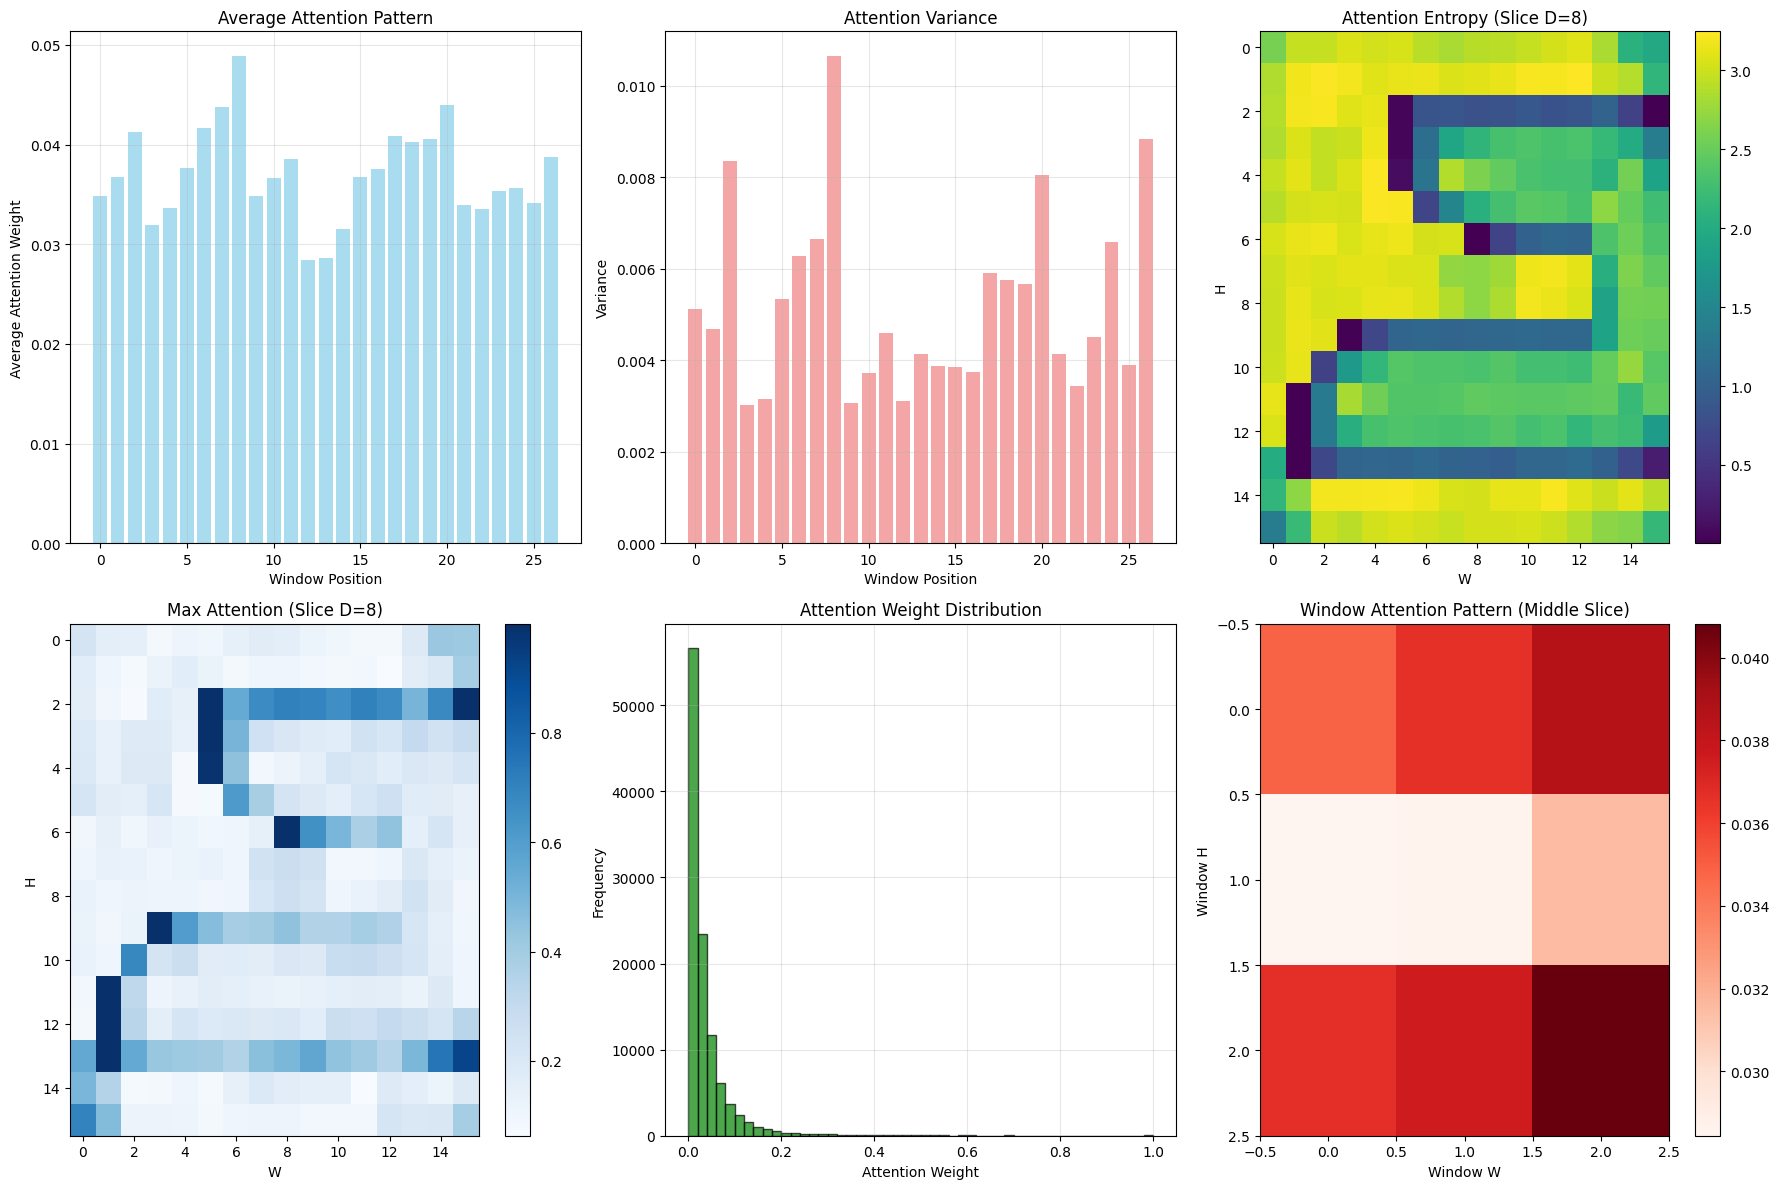


Attention Statistics:
Average attention range: 0.0284 - 0.0489
Most attended window position: 8
Least attended window position: 12
Average entropy: 2.3362
Entropy range: 0.0002 - 3.2742
Attention weights shape: torch.Size([1, 6, 16, 16, 16, 27])


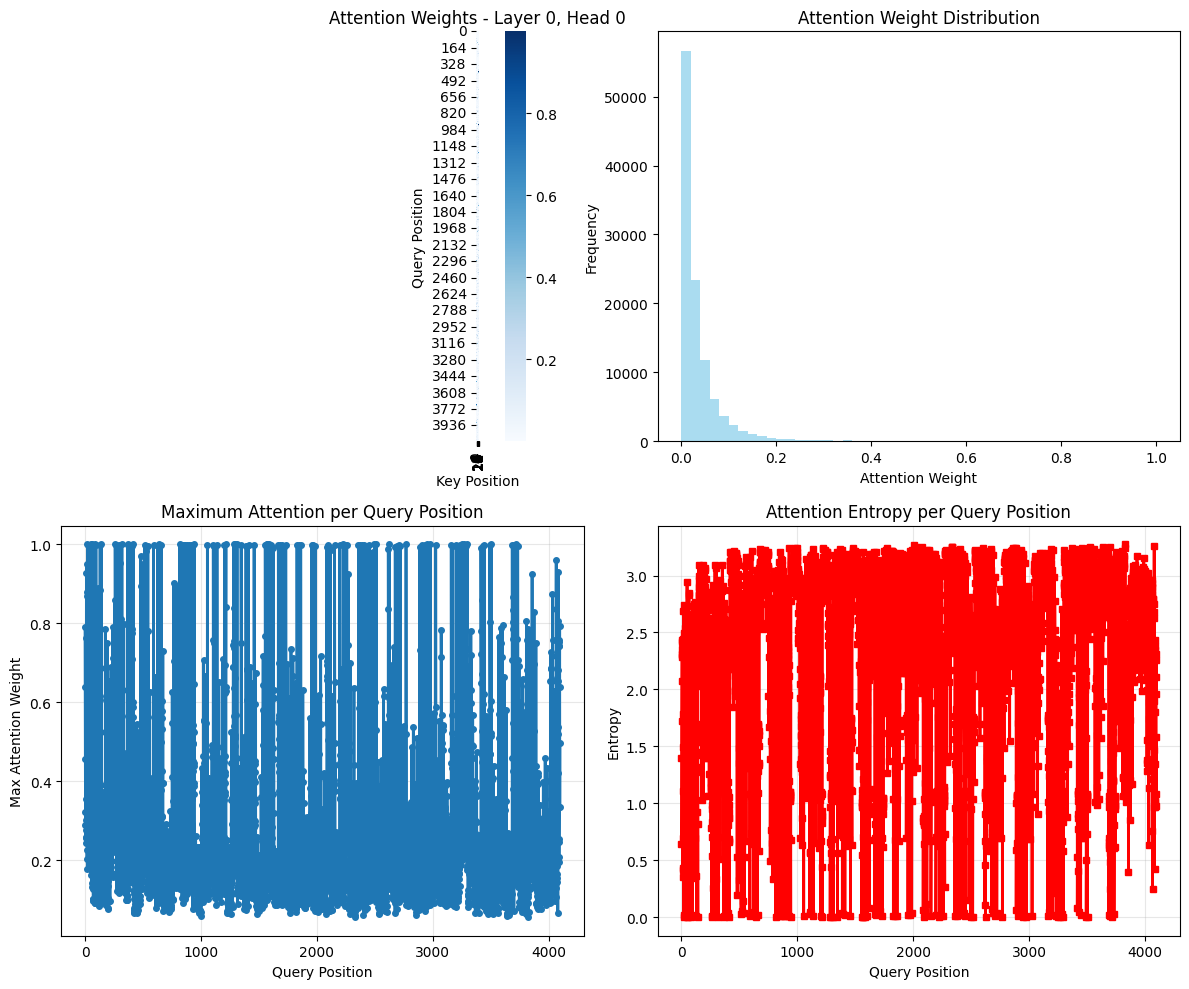

Original attention shape: torch.Size([1, 6, 16, 16, 16, 27])
After selection: torch.Size([16, 16, 16, 27])


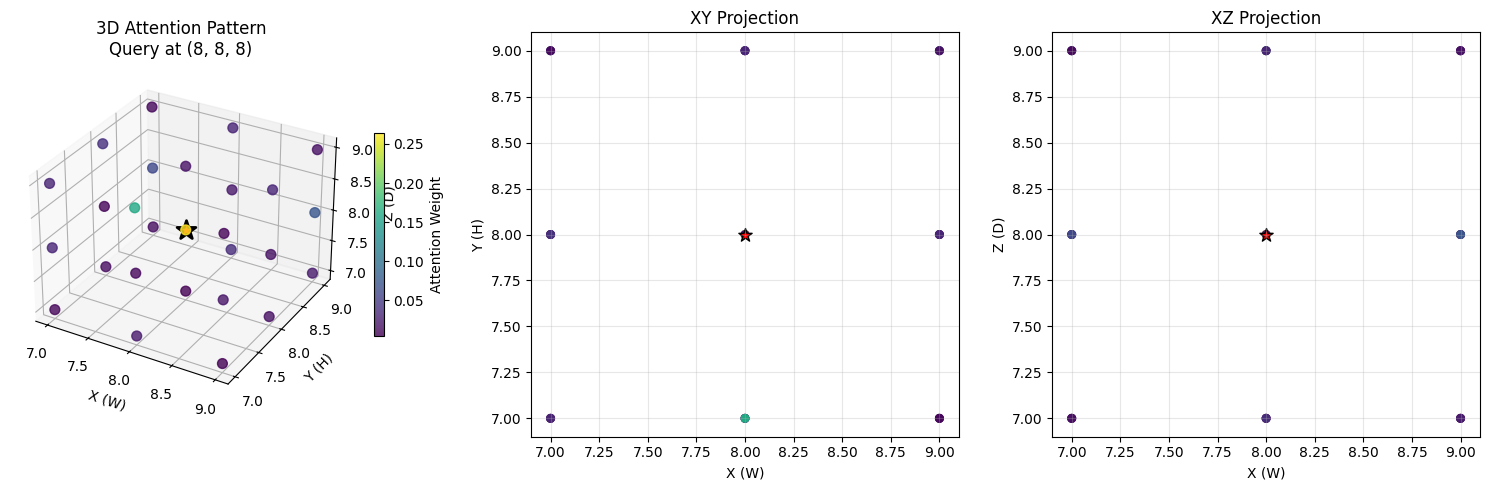

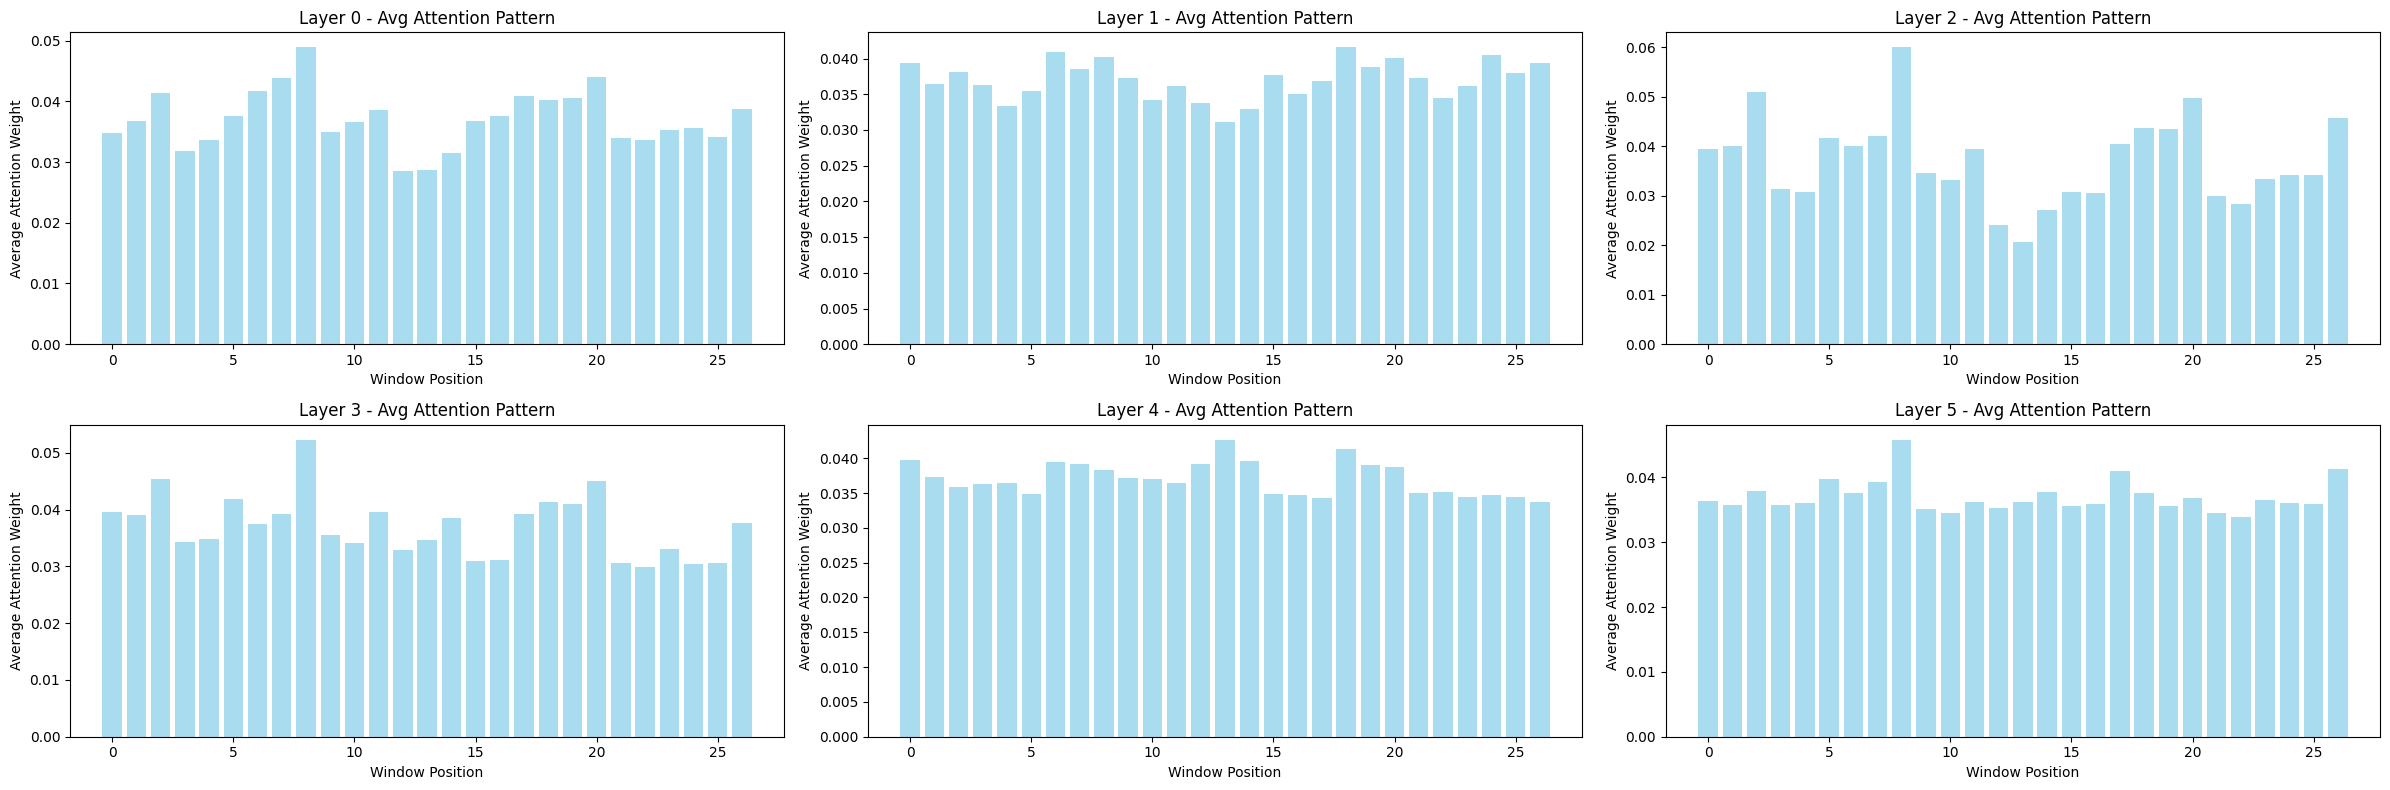

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

def test_model_with_attention(model_path, test_set, sample_idx=0, threshold=0.5, device=None):
    """Modified inference function that captures attention weights"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = VoxelCompletionTransformer(
        d_model=48,
        num_heads=6,
        num_layers=6,
        window_size=3,
        dropout=0.1
    ).to(device)
    
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Hook to capture attention weights
    attention_weights = []
    
    def attention_hook(module, input, output):
        # Capture attention weights from each attention layer
        if hasattr(module, 'attn_weights'):
            attention_weights.append(module.attn_weights.detach().cpu())
    
    # Register hooks on attention layers
    for name, module in model.named_modules():
        if 'attention' in name.lower() or 'attn' in name.lower():
            module.register_forward_hook(attention_hook)
    
    complete, partial = test_set[sample_idx]
    filled_complete = (complete > 0).sum()
    filled_partial = ((complete > 0) & (partial > 0)).sum()
    missing_percent = (filled_complete - filled_partial) / filled_complete
    
    print("Missing Percentage: ", missing_percent)
    ptl = partial
    partial = partial.unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(partial)
    
    output = torch.sigmoid(output)
    output[0, 0][ptl == 1] = 1.0
    output = output.squeeze().cpu()
    
    # Process output
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            for k in range(output.shape[2]):
                if output[i, j, k] > threshold:
                    output[i, j, k] = 1.0
                else:
                    output[i, j, k] = 0.0
    
    # Save outputs
    out_path = "output_voxel.npy"
    complete_path = "complete_voxel.npy"
    partial_path = "partial_voxel.npy"
    
    np.save(out_path, output.numpy())
    np.save(complete_path, complete)
    np.save(partial_path, ptl)
    
    print("Sample Index: ", sample_idx)
    print(f"Output saved to {out_path}")
    
    return output, attention_weights, partial.squeeze(), complete, ptl

def visualize_attention_weights(attention_weights, layer_idx=0, head_idx=0, save_path="attention_viz.png"):
    """Visualize attention weights for a specific layer and head"""
    if len(attention_weights) == 0:
        print("No attention weights captured. Make sure your model has attention layers with 'attention_weights' attribute.")
        return
    
    if layer_idx >= len(attention_weights):
        print(f"Layer {layer_idx} not found. Available layers: 0-{len(attention_weights)-1}")
        return
    
    attn = attention_weights[layer_idx]
    print(f"Attention weights shape: {attn.shape}")
    
    # Handle different attention weight shapes
    if len(attn.shape) == 6:  # [batch, heads, D, H, W, window_size]
        attn = attn[0, head_idx]  # Select first batch, specific head -> [D, H, W, window_size]
        # Reshape to 2D for visualization: [D*H*W, window_size]
        attn = attn.reshape(-1, attn.shape[-1])
    elif len(attn.shape) == 5:  # [heads, D, H, W, window_size]
        attn = attn[head_idx]  # Select specific head -> [D, H, W, window_size]
        attn = attn.reshape(-1, attn.shape[-1])
    elif len(attn.shape) == 4:  # [batch, heads, seq_len, seq_len]
        attn = attn[0, head_idx]  # Select first batch, specific head
    elif len(attn.shape) == 3:  # [heads, seq_len, seq_len]
        attn = attn[head_idx]  # Select specific head
    
    plt.figure(figsize=(12, 10))
    
    # Create heatmap
    plt.subplot(2, 2, 1)
    sns.heatmap(attn.numpy(), cmap='Blues', cbar=True, square=True)
    plt.title(f'Attention Weights - Layer {layer_idx}, Head {head_idx}')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    
    # Attention distribution histogram
    plt.subplot(2, 2, 2)
    plt.hist(attn.numpy().flatten(), bins=50, alpha=0.7, color='skyblue')
    plt.title('Attention Weight Distribution')
    plt.xlabel('Attention Weight')
    plt.ylabel('Frequency')
    
    # Max attention per query
    plt.subplot(2, 2, 3)
    max_attn = torch.max(attn, dim=1)[0]
    plt.plot(max_attn.numpy(), marker='o', linewidth=2, markersize=4)
    plt.title('Maximum Attention per Query Position')
    plt.xlabel('Query Position')
    plt.ylabel('Max Attention Weight')
    plt.grid(True, alpha=0.3)
    
    # Attention entropy (attention spread)
    plt.subplot(2, 2, 4)
    entropy = -torch.sum(attn * torch.log(attn + 1e-9), dim=1)
    plt.plot(entropy.numpy(), marker='s', linewidth=2, markersize=4, color='red')
    plt.title('Attention Entropy per Query Position')
    plt.xlabel('Query Position')
    plt.ylabel('Entropy')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def visualize_3d_attention(attention_weights, voxel_shape=(16, 16, 16), layer_idx=0, head_idx=0, 
                          query_pos=None, save_path="attention_3d.png"):
    """Visualize 3D attention patterns for voxel data"""
    if len(attention_weights) == 0:
        print("No attention weights captured.")
        return
    
    attn = attention_weights[layer_idx]
    print(f"Original attention shape: {attn.shape}")
    
    # Handle 6D attention weights [batch, heads, D, H, W, window_size]
    if len(attn.shape) == 6:
        attn = attn[0, head_idx]  # Select first batch and head -> [D, H, W, window_size]
    elif len(attn.shape) == 5:
        attn = attn[head_idx]  # Select head -> [D, H, W, window_size]
    elif len(attn.shape) == 4:
        attn = attn[0, head_idx]
    elif len(attn.shape) == 3:
        attn = attn[head_idx]
    
    print(f"After selection: {attn.shape}")
    
    # For windowed attention, we need to handle this differently
    if len(attn.shape) == 4:  # [D, H, W, window_size]
        D, H, W, window_size = attn.shape
        
        # Select a specific voxel position to visualize its attention
        if query_pos is None:
            query_d, query_h, query_w = D//2, H//2, W//2  # Center voxel
        else:
            query_d, query_h, query_w = query_pos
        
        # Get attention weights for this query position
        attention_values = attn[query_d, query_h, query_w].numpy()  # [window_size]
        
        # Create 3D visualization showing attention within the local window
        fig = plt.figure(figsize=(15, 5))
        
        # Calculate window positions relative to query
        window_radius = int(np.cbrt(window_size)) // 2  # Assuming cubic window
        positions = []
        
        idx = 0
        for dz in range(-window_radius, window_radius + 1):
            for dy in range(-window_radius, window_radius + 1):
                for dx in range(-window_radius, window_radius + 1):
                    if idx < window_size:
                        # Absolute positions
                        abs_d = max(0, min(D-1, query_d + dz))
                        abs_h = max(0, min(H-1, query_h + dy))
                        abs_w = max(0, min(W-1, query_w + dx))
                        positions.append([abs_w, abs_h, abs_d])  # x, y, z
                        idx += 1
        
        positions = np.array(positions)
        
        # 3D scatter plot
        ax1 = fig.add_subplot(131, projection='3d')
        scatter = ax1.scatter(positions[:, 0], positions[:, 1], positions[:, 2], 
                             c=attention_values, cmap='viridis', s=50, alpha=0.8)
        
        # Highlight query position
        query_3d = [query_w, query_h, query_d]
        ax1.scatter(query_3d[0], query_3d[1], query_3d[2], 
                   c='red', s=200, marker='*', edgecolors='black', linewidth=2)
        
        ax1.set_xlabel('X (W)')
        ax1.set_ylabel('Y (H)')
        ax1.set_zlabel('Z (D)')
        ax1.set_title(f'3D Attention Pattern\nQuery at ({query_w}, {query_h}, {query_d})')
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax1, shrink=0.5)
        cbar.set_label('Attention Weight')
        
        # 2D projections
        ax2 = fig.add_subplot(132)
        scatter2 = ax2.scatter(positions[:, 0], positions[:, 1], c=attention_values, cmap='viridis', s=30)
        ax2.scatter(query_3d[0], query_3d[1], c='red', s=100, marker='*', edgecolors='black')
        ax2.set_xlabel('X (W)')
        ax2.set_ylabel('Y (H)')
        ax2.set_title('XY Projection')
        ax2.grid(True, alpha=0.3)
        
        ax3 = fig.add_subplot(133)
        scatter3 = ax3.scatter(positions[:, 0], positions[:, 2], c=attention_values, cmap='viridis', s=30)
        ax3.scatter(query_3d[0], query_3d[2], c='red', s=100, marker='*', edgecolors='black')
        ax3.set_xlabel('X (W)')
        ax3.set_ylabel('Z (D)')
        ax3.set_title('XZ Projection')
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return query_d, query_h, query_w
    
    else:
        # Fallback for other shapes
        print(f"Unexpected attention shape: {attn.shape}")
        return None

def visualize_attention_across_layers(attention_weights, save_path="attention_layers.png"):
    """Compare attention patterns across different layers"""
    if len(attention_weights) == 0:
        print("No attention weights captured.")
        return
    
    num_layers = len(attention_weights)
    fig, axes = plt.subplots(2, (num_layers + 1) // 2, figsize=(4 * num_layers, 8))
    
    if num_layers == 1:
        axes = [axes]
    elif num_layers > 1:
        axes = axes.flatten()
    
    for i, attn in enumerate(attention_weights):
        # Handle 6D attention weights
        if len(attn.shape) == 6:  # [batch, heads, D, H, W, window_size]
            attn = attn[0, 0]  # First batch, first head -> [D, H, W, window_size]
            # Average over spatial dimensions to get [window_size] pattern
            attn = attn.mean(dim=(0, 1, 2))  # Average over D, H, W
        elif len(attn.shape) == 5:  # [heads, D, H, W, window_size]
            attn = attn[0]  # First head -> [D, H, W, window_size]
            attn = attn.mean(dim=(0, 1, 2))
        elif len(attn.shape) == 4:  # [batch, heads, seq_len, seq_len]
            attn = attn[0, 0]  # First batch, first head
        elif len(attn.shape) == 3:  # [heads, seq_len, seq_len]
            attn = attn[0]  # First head
        
        ax = axes[i] if num_layers > 1 else axes
        
        # If we have a 1D attention pattern (from averaging), show as bar plot
        if len(attn.shape) == 1:
            ax.bar(range(len(attn)), attn.numpy(), alpha=0.7, color='skyblue')
            ax.set_title(f'Layer {i} - Avg Attention Pattern')
            ax.set_xlabel('Window Position')
            ax.set_ylabel('Average Attention Weight')
        else:
            # Create heatmap for 2D attention
            im = ax.imshow(attn.numpy(), cmap='Blues', aspect='auto')
            ax.set_title(f'Layer {i}')
            ax.set_xlabel('Key Position')
            ax.set_ylabel('Query Position')
            
            # Add colorbar
            plt.colorbar(im, ax=ax)
    
    # Hide unused subplots
    for i in range(num_layers, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def analyze_windowed_attention(attention_weights, layer_idx=0, head_idx=0, save_path="windowed_attention.png"):
    """Analyze attention patterns in windowed (local) attention"""
    if len(attention_weights) == 0:
        print("No attention weights captured.")
        return
    
    attn = attention_weights[layer_idx]
    
    # Handle 6D attention weights [batch, heads, D, H, W, window_size]
    if len(attn.shape) == 6:
        attn = attn[0, head_idx]  # Select first batch and head -> [D, H, W, window_size]
    elif len(attn.shape) == 5:
        attn = attn[head_idx]  # Select head -> [D, H, W, window_size]
    
    print(f"Analyzing windowed attention with shape: {attn.shape}")
    
    D, H, W, window_size = attn.shape
    
    # Convert to numpy for easier manipulation
    attn_np = attn.numpy()
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Average attention pattern across all spatial positions
    avg_attention = np.mean(attn_np, axis=(0, 1, 2))  # Average over D, H, W
    axes[0, 0].bar(range(window_size), avg_attention, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Average Attention Pattern')
    axes[0, 0].set_xlabel('Window Position')
    axes[0, 0].set_ylabel('Average Attention Weight')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Attention variance across spatial positions
    var_attention = np.var(attn_np, axis=(0, 1, 2))
    axes[0, 1].bar(range(window_size), var_attention, alpha=0.7, color='lightcoral')
    axes[0, 1].set_title('Attention Variance')
    axes[0, 1].set_xlabel('Window Position')
    axes[0, 1].set_ylabel('Variance')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Attention entropy distribution
    # Calculate entropy for each spatial position
    entropy_map = np.zeros((D, H, W))
    for d in range(D):
        for h in range(H):
            for w in range(W):
                probs = attn_np[d, h, w]
                probs = probs + 1e-9  # Add small epsilon to avoid log(0)
                entropy_map[d, h, w] = -np.sum(probs * np.log(probs))
    
    # Show entropy for middle slice
    middle_slice = entropy_map[D//2, :, :]
    im1 = axes[0, 2].imshow(middle_slice, cmap='viridis', aspect='auto')
    axes[0, 2].set_title(f'Attention Entropy (Slice D={D//2})')
    axes[0, 2].set_xlabel('W')
    axes[0, 2].set_ylabel('H')
    plt.colorbar(im1, ax=axes[0, 2])
    
    # 4. Attention focus (max attention weight) across space
    max_attention = np.max(attn_np, axis=-1)  # Max over window_size
    middle_slice_max = max_attention[D//2, :, :]
    im2 = axes[1, 0].imshow(middle_slice_max, cmap='Blues', aspect='auto')
    axes[1, 0].set_title(f'Max Attention (Slice D={D//2})')
    axes[1, 0].set_xlabel('W')
    axes[1, 0].set_ylabel('H')
    plt.colorbar(im2, ax=axes[1, 0])
    
    # 5. Attention distribution histogram
    axes[1, 1].hist(attn_np.flatten(), bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 1].set_title('Attention Weight Distribution')
    axes[1, 1].set_xlabel('Attention Weight')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Window position preference
    # Reshape window to 3D coordinates assuming cubic window
    window_cube_size = int(np.cbrt(window_size))
    if window_cube_size ** 3 == window_size:
        window_3d = avg_attention.reshape(window_cube_size, window_cube_size, window_cube_size)
        # Show middle slice of the window
        middle_window_slice = window_3d[window_cube_size//2, :, :]
        im3 = axes[1, 2].imshow(middle_window_slice, cmap='Reds', aspect='auto')
        axes[1, 2].set_title(f'Window Attention Pattern (Middle Slice)')
        axes[1, 2].set_xlabel('Window W')
        axes[1, 2].set_ylabel('Window H')
        plt.colorbar(im3, ax=axes[1, 2])
    else:
        # If not cubic, show as 1D
        axes[1, 2].plot(avg_attention, marker='o', linewidth=2, markersize=4)
        axes[1, 2].set_title('Window Attention Pattern')
        axes[1, 2].set_xlabel('Window Position')
        axes[1, 2].set_ylabel('Attention Weight')
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print some statistics
    print(f"\nAttention Statistics:")
    print(f"Average attention range: {avg_attention.min():.4f} - {avg_attention.max():.4f}")
    print(f"Most attended window position: {np.argmax(avg_attention)}")
    print(f"Least attended window position: {np.argmin(avg_attention)}")
    print(f"Average entropy: {np.mean(entropy_map):.4f}")
    print(f"Entropy range: {entropy_map.min():.4f} - {entropy_map.max():.4f}")


output, attention_weights, partial, complete, ptl = test_model_with_attention(
    model_path=MODEL_SAVE_PATH,
    test_set=test_set,
    sample_idx=0
)

# Visualize attention weights
if attention_weights:
    analyze_windowed_attention(attention_weights, layer_idx=0, head_idx=0)
    visualize_attention_weights(attention_weights, layer_idx=0, head_idx=0)
    visualize_3d_attention(attention_weights, layer_idx=0, head_idx=0)
    visualize_attention_across_layers(attention_weights)
else:
    print("No attention weights captured. You may need to modify your model to store attention weights.")